# Model comparison to GO-SHIP Easy Ocean
This notebook shows a means of comparing MOM6 ocean model data to WOCE/GO-SHIP sections. These sections have been interpolated onto consistent lat-lon-pressure coordinates for ease of comparison with ocean model data. See [here](https://cchdo.ucsd.edu/products/goship-easyocean) for information on observational data and interpolation details.

In [6]:
import pandas as pd
from cartopy import crs as ccrs
import matplotlib.pyplot as plt
import xarray as xr
import numpy as np
import gfdl_utils as gu
import glob

## Plot options
Specify a WOCE/GO-SHIP section line to look at, and a year range for the model.

In [25]:
line = 'P09'
time = '2005-2009'

## Read model data

In [26]:
pathDict = {'pp':'/archive/Raphael.Dussin/FMS2019.01.03_devgfdl_20221223/CM4_historical_c192_OM4p25/gfdl.ncrc4-intel18-prod-openmp/pp',
            'out':'av'}
pathDict['ppname']='ocean_annual_z_1x1deg'
pathDict['time']=time
pathDict['local']='annual_5yr'
pathDict['add']='ann'

In [27]:
dsm = gu.core.open_frompp(**pathDict)

## Read GO-SHIP Easy Ocean data

In [28]:
rootdir = glob.glob('/work/gam/GO-SHIP/gridded/*/'+line)[0]
# See all possible iterations of this WOCE line
filenames = line.lower()+'_*.xyz'
path = '/'.join([rootdir,filenames])
# Get list of available years
years = []
for file in glob.glob(path):
    years.append(int(file[-8:-4]))
years = np.array(years)
# Find year closest to model year
yearo = years[np.argmin(np.abs(dsm['time.year'].values-years))]
yearo

# Read in .xyz file
filename = line.lower()+'_'+str(yearo)+'.xyz'
path = '/'.join([rootdir,filename])
df = pd.read_csv(path,skiprows=[0,1],delim_whitespace=True,
                names=['Lat/Lon','pressure','temperature',
                      'practical_salinity','oxygen',
                      'conservative_temperature','absolute_salinity'],
                na_values=-999)

# Convert to xarray DataArray
dims = list(df.columns[0:2].values)
coords = {dims[0]:df[dims[0]].unique(),
          dims[1]:df[dims[1]].unique()}

dso = xr.Dataset(coords=coords)
for variable in df.columns[2:]:
    da = xr.DataArray(dims=dims,coords=coords,name=variable)
    data = np.reshape(df['temperature'].values,
                    newshape=da.shape)
    da.data = data
    dso[variable] = da
dso = dso.transpose()

# Retrieve missing lat/lon value
# (.xyz only give one horizontal dimension)
filename = line.lower()+'.nc'
path = '/'.join([rootdir,filename])
dso_nc = xr.open_dataset(path)
# And assign appropriately
if len(dso_nc['latitude'])==1:
    dimx = 'longitude'
    dso=dso.rename({'Lat/Lon':dimx})
    dso['latitude']=dso_nc['latitude']
elif len(dso_nc['longitude'])==1:
    dimx = 'latitude'
    dso=dso.rename({'Lat/Lon':dimx})
    dso['longitude']=dso_nc['longitude']
    
# Change temperature and salinity names to match model
dso = dso.rename({'temperature':'thetao','practical_salinity':'so'})

## Interpolate model data to location of observations

In [29]:
dsmo = dsm.interp({'lat':dso['latitude'],'lon':dso['longitude'],'z_l':dso['pressure']}).squeeze()

/nbhome/gam/miniconda3/envs/om4labs/lib/python3.9/site-packages/cartopy/crs.py:228: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/nbhome/gam/miniconda3/envs/om4labs/lib/python3.9/site-packages/cartopy/crs.py:280: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
/nbhome/gam/miniconda3/envs/om4labs/lib/python3.9/site-packages/cartopy/crs.py:347: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(p_mline) > 0:


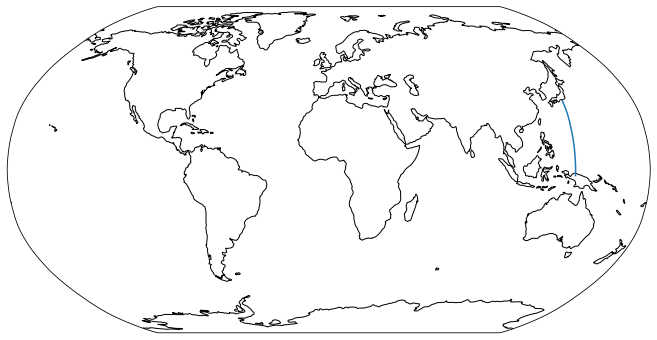

In [30]:
if dimx=='longitude':
    x=dso['longitude'].values
    y=dso['latitude']*xr.ones_like(dso['longitude']).squeeze().values
elif dimx=='latitude':
    x=dso['longitude']*xr.ones_like(dso['latitude']).squeeze().values
    y=dso['latitude'].values
    
fig,ax=plt.subplots(figsize=(12,6),subplot_kw={'projection':ccrs.Robinson()})
ax.set_global()
ax.plot(x,y,transform=ccrs.PlateCarree())
ax.coastlines()

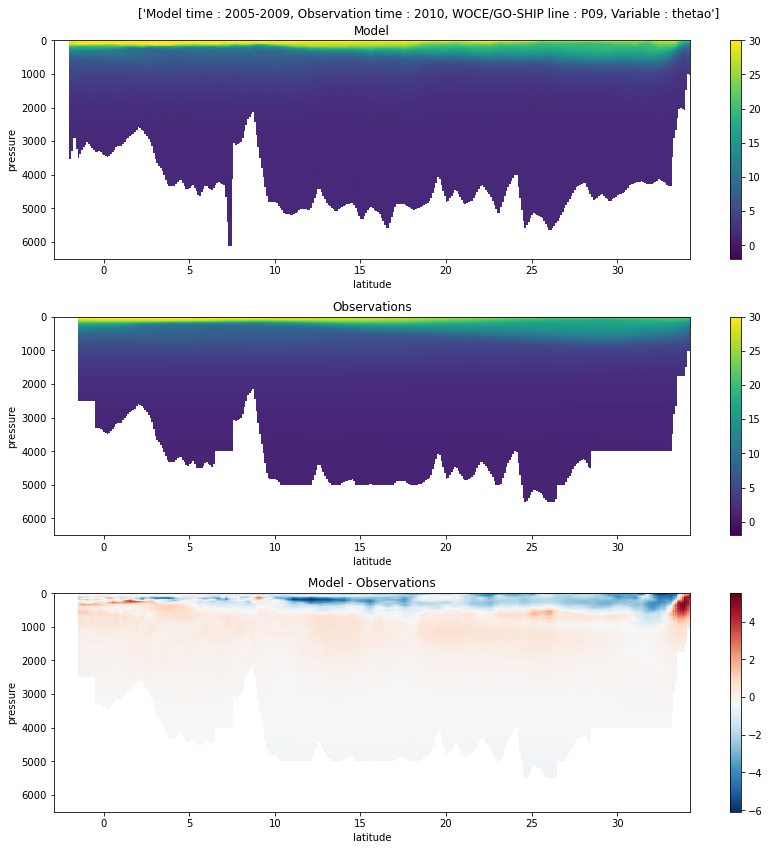

In [34]:
variable = 'thetao'
x = dso[dimx]
y = dso['pressure']
zo = dso[variable]
zm = dsmo[variable].where(np.isfinite(dso[variable]))

kwargs = {'thetao':{'vmin':-2,'vmax':30},'so':{'vmin':33,'vmax':36}}

fig,ax = plt.subplots(figsize=(12,12),nrows=3)

fig.suptitle(['Model time : '+time+
              ', Observation time : '+str(yearo)+
              ', WOCE/GO-SHIP line : '+line+
              ', Variable : '+variable])

im = ax[0].pcolormesh(x,y,zo,**kwargs[variable])
ax[0].invert_yaxis()
ax[0].set_title('Model')
ax[0].set_xlabel(dimx)
ax[0].set_ylabel('pressure')
plt.colorbar(im,ax=ax[0])

im = ax[1].pcolormesh(x,y,zm,**kwargs[variable])
ax[1].invert_yaxis()
ax[1].set_title('Observations')
ax[1].set_xlabel(dimx)
ax[1].set_ylabel('pressure')
plt.colorbar(im,ax=ax[1])

im = ax[2].pcolormesh(x,y,zm-zo,cmap='RdBu_r')
ax[2].invert_yaxis()
ax[2].set_title('Model - Observations')
ax[2].set_xlabel(dimx)
ax[2].set_ylabel('pressure')
plt.colorbar(im,ax=ax[2])

fig.tight_layout()